# Imports

In [1]:
import os
import sys
import pickle
from datetime import datetime
from typing import (
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

from joblib import (
    delayed, 
    Parallel
)

from matplotlib import pyplot as plt

# Paths

In [148]:
NOTEBOOKS_PATH: str = os.getcwd()
SETTINGS_PATH: str = NOTEBOOKS_PATH.replace("notebooks", "settings")
RESULTS_PATH: str = os.path.join(NOTEBOOKS_PATH, "results")
QSRR_IC_PATH: str = os.path.dirname(NOTEBOOKS_PATH)

SINGLE_TRAIN_PATH: str = os.path.join(SETTINGS_PATH, "single_train.json")

In [3]:
for path_ in {NOTEBOOKS_PATH, QSRR_IC_PATH, SETTINGS_PATH}:
    print(f"Path : {path_}")

Path : C:\Users\petar\PycharmProjects\QSRR_IC
Path : C:\Users\petar\PycharmProjects\QSRR_IC\notebooks
Path : C:\Users\petar\PycharmProjects\QSRR_IC\settings


In [4]:
if QSRR_IC_PATH not in sys.path:
    sys.path.append(QSRR_IC_PATH)

In [5]:
# Change the working dir to QSRR IC path
os.chdir(QSRR_IC_PATH)

# QSRR IC module imports

In [6]:
from qsrr_ic.analysis.srd import (
    SumOfRankingDifferences,
    SrdVisualizer
)
from qsrr_ic.analysis.srd.domain_models import SrdSettings
from qsrr_ic.config import (
    HyperParameterConfig,
    QsrrIcConfig
)
from qsrr_ic.enums import RegressorType
from qsrr_ic.load import (
    load_dataset,
    QsrrIcData,
    QsrrIcDataset
)
from qsrr_ic.models.iso2grad import Iso2Grad
from qsrr_ic.models.iso2grad.domain_models import Iso2GradData
from qsrr_ic.models.qsrr import QsrrModel
from qsrr_ic.models.qsrr.domain_models import QsrrData
from qsrr_ic.process import ProcessData
from qsrr_ic.runners import (
    QsrrIcModelRunner,    
    QsrrModelRunner,
    QsrrResamplingWithReplacementModelRunner
)

# Single Train

This example shows how to train models using the quantitative structure-retention relationships (QSRR) model & isocratic to gradient (Iso2Grad) model APIs, estimate confidence intervals (CIs) of predictions and metrics using resampling with resplacement, and analyze the models using sum of ranking differences (SRD) / define the models' applicability domain (AD).

## Instantiate `QsrrIcConfig` object using the "single_train.json" example
- `QsrrIcConfig` is an object used to load all configs & settings
- Can be instantiated in three ways:
  * Using the constructor, takes individual config classes, as attributes
  * Using the factory method `QsrrIcConfig::from_dict()` which takes a dictionary of configs/settings
  * Using the method `QsrrIcConfig::from_json(filename="filename.json")` that loads a dictionary of config/settings & instantiates `QsrrIcConfig` using the factory method `QsrrIcConfig::from_dict()`

In [7]:
single_train_config: QsrrIcConfig = QsrrIcConfig.from_json(filename=SINGLE_TRAIN_PATH)

In [8]:
single_train_config.to_dict()

{'dataset': {'molecular_descriptors_for_qsrr_training_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_qsrr_training.csv',
  'isocratic_retention_path': './datasets/qsrr_ic/2025-01-05-isocratic_retention.csv',
  'molecular_descriptors_for_iso2grad_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_iso2grad.csv',
  'gradient_void_times_path': './datasets/qsrr_ic/2025-01-05-gradient_void_times.csv',
  'gradient_profiles_path': './datasets/qsrr_ic/2025-01-05-gradient_profiles.csv',
  'gradient_retention_path': './datasets/qsrr_ic/2025-01-05-gradient_retention.csv'},
 'training_type': 'single_train',
 'train_test_split': {'test_ratio': 0.7, 'random_seed': None, 'shuffle': True},
 'hyper_parameters': {'PLS': {'n_components': 4},
  'xGB': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2},
  'GBR': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2},
  'RFR': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1},
  'ADA': {'n_estimators'

## Load & Prepare Data

In [9]:
# Load the dataset
dataset: QsrrIcDataset = load_dataset(single_train_config.dataset_config)

# Process dataset for training
data: QsrrIcData = ProcessData(dataset).process()

# Prepare & split QSRR data to train/test
qsrr_data: QsrrData = QsrrData(
    y=data.isocratic_retention,
    x=data.molecular_descriptors_for_qsrr_training
)
qsrr_train_data, qsrr_test_data = qsrr_data.split(single_train_config.train_test_split_config)

## Train QSRR models

Configuration class `QsrrIcConfig`, among others, contains an dictionary of `RegressorType`:`HyperParameterConfig` key:value pairs. `HyperParameterConfig` contains an instance of the HyperParameterRegistry that stores hyper-parameters (for single train) or hyper-parameter ranges (for optimization). 

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `HyperParameterConfigs`, then instantiate `QsrrModelRunner` that returns instance of `QsrrModel`. `QsrrModel` can also be invoked without using the `QsrrModelRunner` class.

In [10]:
qsrr_models: Dict[RegressorType, QsrrModel] = {}

for regressor_type, hyper_parameter_config in single_train_config.hyper_parameter_config.items():
    
    print(f"Training model: {hyper_parameter_config.to_dict()}")
    
    model_runner = QsrrModelRunner()

    model: QsrrModel = model_runner.run(
        regressor_type=regressor_type,
        qsrr_train_data=qsrr_train_data,
        qsrr_test_data=qsrr_test_data,
        config=hyper_parameter_config
    )
    
    qsrr_models[regressor_type] = model

Training model: {'regressor_type': 'PLS', 'hyper_parameters': {'n_components': 4}}
Training model: {'regressor_type': 'xGB', 'hyper_parameters': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'GBR', 'hyper_parameters': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'RFR', 'hyper_parameters': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}}
Training model: {'regressor_type': 'ADA', 'hyper_parameters': {'n_estimators': 676, 'learning_rate': 0.1284015}}


In [11]:
qsrr_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10e9305c8b0>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10eea99a100>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10e9305c9d0>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10e962724c0>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10e962727c0>}

In [12]:
qsrr_model_metrics: Dict[RegressorType, DataFrame] = {}

for regressor_type in single_train_config.hyper_parameter_config:
    print(f"Model: {regressor_type.name}")
    print(f"Hyper-parameters: {qsrr_models[regressor_type].hyper_parameters.to_dict()}")
    train_metrics: DataFrame = qsrr_models[regressor_type].train_results.qsrr_metrics.to_df()
    test_metrics: DataFrame = qsrr_models[regressor_type].test_results.qsrr_metrics.to_df()
    qsrr_model_metrics_: DataFrame = pd.concat((train_metrics, test_metrics), axis=1)
    qsrr_model_metrics_.columns = ["Training set", "Test set"]
    qsrr_model_metrics[regressor_type] = qsrr_model_metrics_

qsrr_model_metrics_df: DataFrame = pd.concat(
    [df for df in qsrr_model_metrics.values()],
    axis=1,
    keys=qsrr_model_metrics.keys()
)

print()
print(f"Performance: ")
display(qsrr_model_metrics_df)

Model: PLS
Hyper-parameters: {'n_components': 4}
Model: xGB
Hyper-parameters: {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}
Model: GBR
Hyper-parameters: {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}
Model: RFR
Hyper-parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}
Model: ADA
Hyper-parameters: {'n_estimators': 676, 'learning_rate': 0.1284015}

Performance: 


RegressorType.PLS           RegressorType.xGB            \
           Training set  Test set      Training set  Test set   
R2             0.949765  0.939500          0.999828  0.993181   
MAE            0.088346  0.105232          0.004831  0.030322   
MSE            0.013180  0.018488          0.000045  0.002084   
RMSE           0.114803  0.135970          0.006717  0.045649   
%MSE         271.029388       NaN          0.322364       NaN   
%RMSE        164.629702       NaN          5.677713       NaN   

      RegressorType.GBR           RegressorType.RFR            \
           Training set  Test set      Training set  Test set   
R2             0.999802  0.993477          0.997852  0.988709   
MAE            0.005123  0.029004          0.013862  0.040880   
MSE            0.000052  0.001993          0.000563  0.003450   
RMSE           0.007206  0.044646          0.023737  0.058740   
%MSE           0.146527       NaN          0.787328       NaN   
%RMSE          3.827883       NaN          8.873151       NaN   

      RegressorType.ADA            
           Training set  Test set  
R2             0.973836  0.963260  
MAE            0.066823  0.083498  
MSE            0.006864  0.011227  
RMSE           0.082852  0.105958  
%MSE         385.600520       NaN  
%RMSE        196.367136       NaN

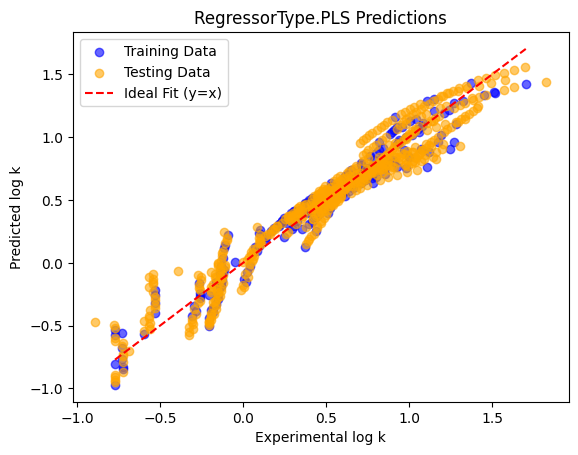

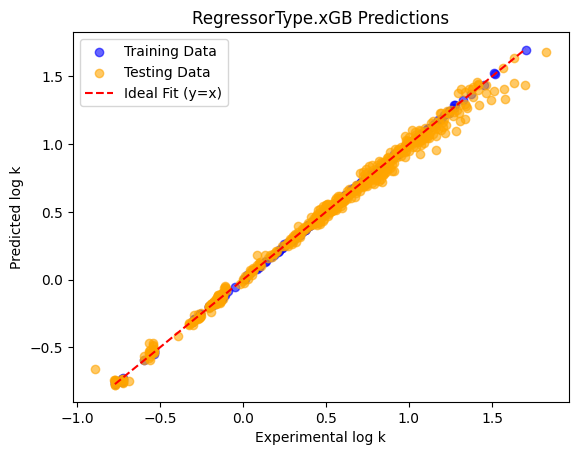

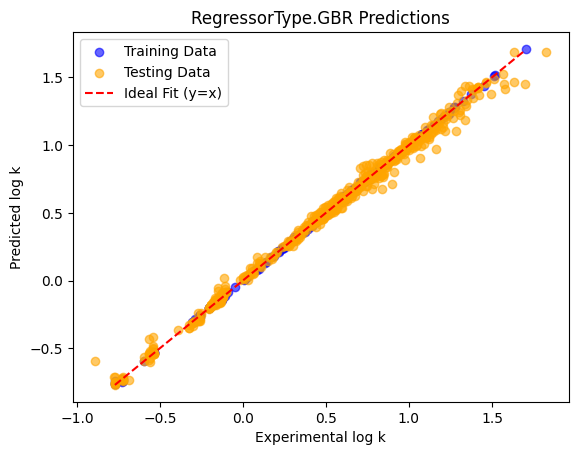

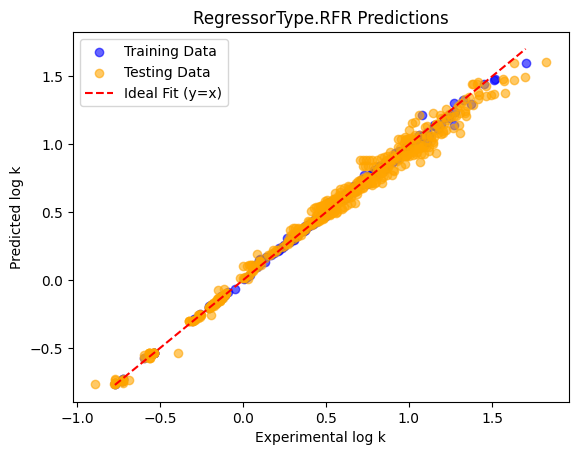

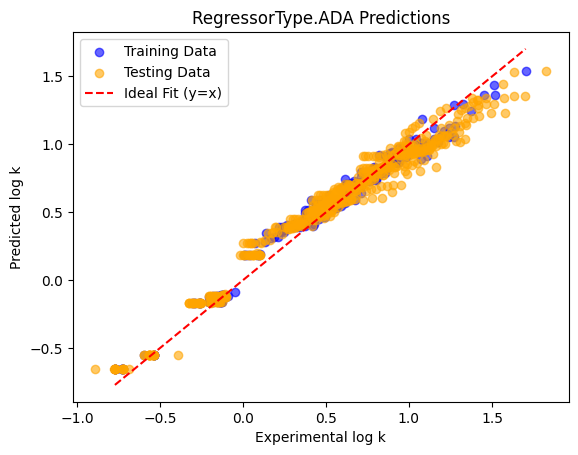

In [13]:
for regressor_type, qsrr_model in qsrr_models.items():
    
    fig, ax = plt.subplots()

    ax.set_title(f"{regressor_type} Predictions")
    ax.set_xlabel("Experimental log k")
    ax.set_ylabel("Predicted log k")

    # Training data scatter plot
    ax.scatter(
        qsrr_model.qsrr_train_data.y,
        qsrr_model.train_results.qsrr_predictions.y,
        label="Training Data",
        alpha=0.6,
        color="blue"
    )

    # Testing data scatter plot
    ax.scatter(
        qsrr_model.qsrr_test_data.y,
        qsrr_model.test_results.qsrr_predictions.y,
        label="Testing Data",
        alpha=0.6,
        color="orange"
    )

    # Diagonal reference line
    ax.plot(
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        color="red", linestyle="--", label="Ideal Fit (y=x)"
    )

    ax.legend()
    plt.show()

## Prepare data & settings for iso2grad model

Below, we prepare settings & data for iso2grad modelling.

Settings:
* Integration step
* Number of Python processes to run Iso2Grad in parallel
* Verbosity if parallel calculation

Data needed:
* Molecular descriptors for iso2grad, all descriptors besides the eluent concentration (will be varied during the iso2grad numerical integration process)
* Void times of gradient calculations
* Gradient profiles, only linear profiles supported now
* Gradient retention times, optional data for validation

In [14]:
iso2grad_settings = single_train_config.iso2grad_config.iso2grad_settings
iso2grad_data = Iso2GradData(
    isocratic_model_predictors=data.molecular_descriptors_for_iso2grad,
    gradient_void_times=data.gradient_void_times,
    gradient_retention_profiles=data.gradient_profiles,
    gradient_retention_times=data.gradient_retention
)

In [15]:
data.molecular_descriptors_for_iso2grad.shape

(29, 54)

In [16]:
print(f"Iso2Grad settings: {iso2grad_settings.__dict__}")

Iso2Grad settings: {'integration_step': 0.01, 'n_jobs': 12, 'verbosity': 10}


## Train iso2grad models

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `QsrrModels`, then instantiate `QsrrIcModelRunner` that returns instance of `Iso2Grad`. `Iso2Grad` can also be invoked without using the `QsrrIcModelRunner` class.

In [17]:
iso2grad_models: Dict[RegressorType, RegressorType] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    
    print(f"Training iso2grad model using {regressor_type.name} QSRR model")
    
    model_runner = QsrrIcModelRunner()

    model: Iso2Grad = model_runner.run(
        qsrr_model=qsrr_model,
        iso2grad_data=iso2grad_data,
        iso2grad_settings=iso2grad_settings
    )
    
    iso2grad_models[regressor_type] = model

Training iso2grad model using PLS QSRR model


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   20.1s remaining:   57.5s
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   21.0s remaining:   35.8s
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:   34.3s remaining:   36.9s
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:   34.7s remaining:   23.8s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:   35.7s remaining:   15.0s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:   36.1s remaining:    8.1s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:   41.4s remaining:    3.2s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:   42.7s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using xGB QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   38.8s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   44.1s remaining:  2.1min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   48.1s remaining:  1.4min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:  1.1min remaining:  1.2min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.2min remaining:   48.7s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.2min remaining:   30.8s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.3min remaining:   17.1s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.4min remaining:    6.7s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using GBR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   33.3s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   38.5s remaining:  1.8min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   39.4s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:  1.1min remaining:  1.2min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.1min remaining:   45.8s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.2min remaining:   29.8s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.2min remaining:   16.2s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.4min remaining:    6.5s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using RFR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:  6.0min remaining: 17.1min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:  6.4min remaining: 10.9min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed: 10.1min remaining: 10.9min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 10.4min remaining:  7.1min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 10.9min remaining:  4.6min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 11.2min remaining:  2.6min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 12.9min remaining:  1.0min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 14.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using ADA QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 43.7min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed: 48.4min remaining: 138.2min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed: 49.8min remaining: 84.7min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed: 85.9min remaining: 92.5min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 86.9min remaining: 59.7min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 91.7min remaining: 38.6min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 92.5min remaining: 21.0min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 112.5min remaining:  9.0min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 119.2min finished


In [18]:
iso2grad_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x10e962de640>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x10ea9874520>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x10ea988f520>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x10ea985da00>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x10ea988f250>}

In [19]:
iso2grad_metrics: List[DataFrame] = []

for regressor_type in iso2grad_models:
    iso2grad_metrics_: DataFrame = iso2grad_models[regressor_type].results.metrics.to_df()
    iso2grad_metrics_.columns = [regressor_type]
    iso2grad_metrics.append(iso2grad_metrics_)

print(f"Performance: ")
iso2grad_metrics_df: DataFrame = pd.concat(iso2grad_metrics, axis=1)
display(iso2grad_metrics_df)

Performance: 


,RegressorType.PLS,RegressorType.xGB,RegressorType.GBR,RegressorType.RFR,RegressorType.ADA
R2,0.872114,0.970409,0.979788,0.959039,0.868775
MAE,1.844975,0.723639,0.588082,0.932663,1.842989
MSE,8.025000,1.856859,1.268326,2.570365,8.234557
RMSE,2.832843,1.362666,1.126200,1.603236,2.869592
%MSE,4.902577,0.568109,0.564588,1.096253,3.207053
%RMSE,22.141765,7.537302,7.513904,10.470209,17.908246


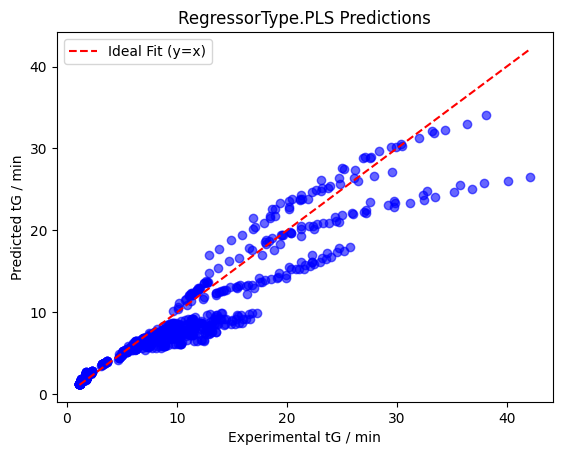

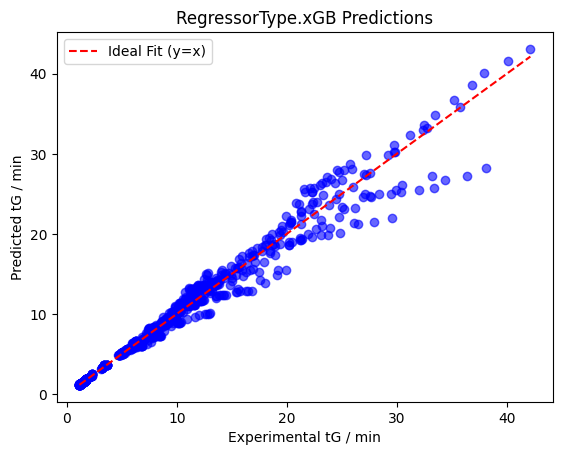

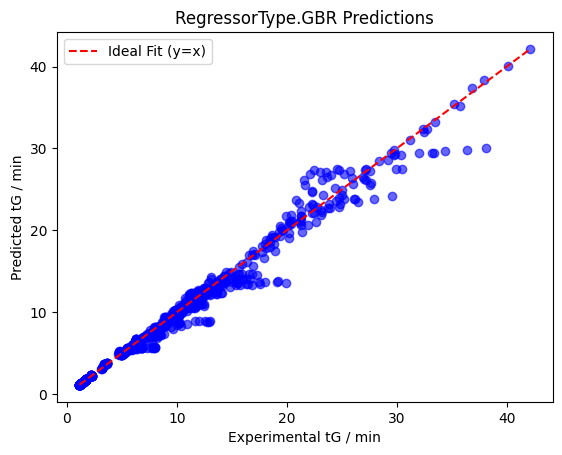

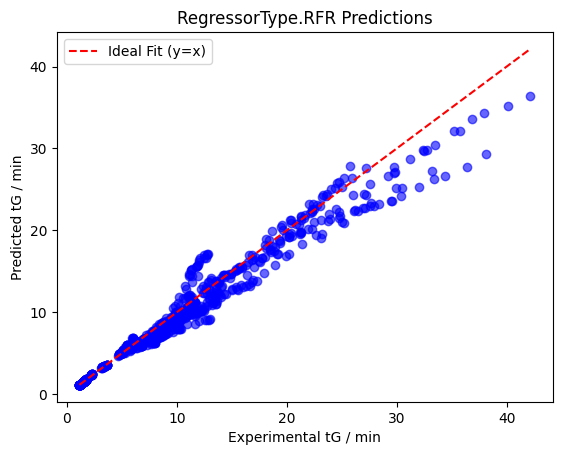

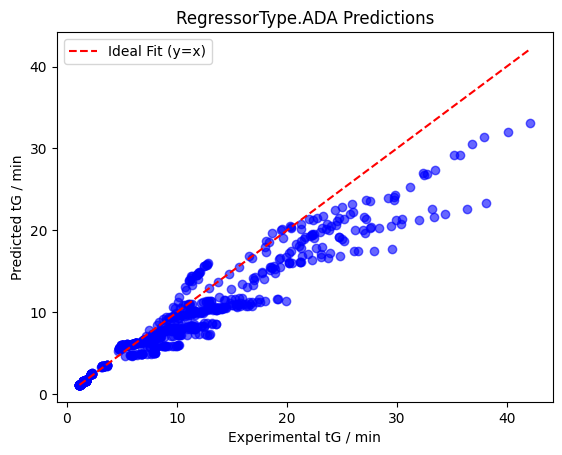

In [20]:
for regressor_type, iso2grad_model in iso2grad_models.items():
    
    fig, ax = plt.subplots()

    ax.set_title(f"{regressor_type} Predictions")
    ax.set_xlabel("Experimental tG / min")
    ax.set_ylabel("Predicted tG / min")

    # Training data scatter plot
    ax.scatter(
        iso2grad_model.results.metrics.qsrr_data.y,
        iso2grad_model.results.metrics.qsrr_predictions.y,
        alpha=0.6,
        color="blue"
    )

    # Diagonal reference line
    ax.plot(
        [min(iso2grad_model.results.metrics.qsrr_data.y), max(iso2grad_model.results.metrics.qsrr_data.y)],
        [min(iso2grad_model.results.metrics.qsrr_data.y), max(iso2grad_model.results.metrics.qsrr_data.y)],
        color="red", linestyle="--", label="Ideal Fit (y=x)"
    )

    ax.legend()
    plt.show()

## SRD Analysis

### SRD for QSRR models

In [21]:
# Calculate SRD for QSRR models
qsrr_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    qsrr_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = predictions
        inputs=np.vstack((qsrr_model.train_results.qsrr_predictions.y, qsrr_model.test_results.qsrr_predictions.y)).reshape(-1, 1),
        # Golden reference = exp retention data
        golden_reference=np.vstack((qsrr_model.qsrr_train_data.y, qsrr_model.qsrr_test_data.y)).reshape(-1, 1)
    )

normalized_srds = np.hstack([qsrr_srd.normalized_srds for qsrr_srd in qsrr_srds.values()])
normalized_random_srds = qsrr_srds[RegressorType.PLS].normalized_random_srds  # Can take from any of the SRD objects as the numbers are random

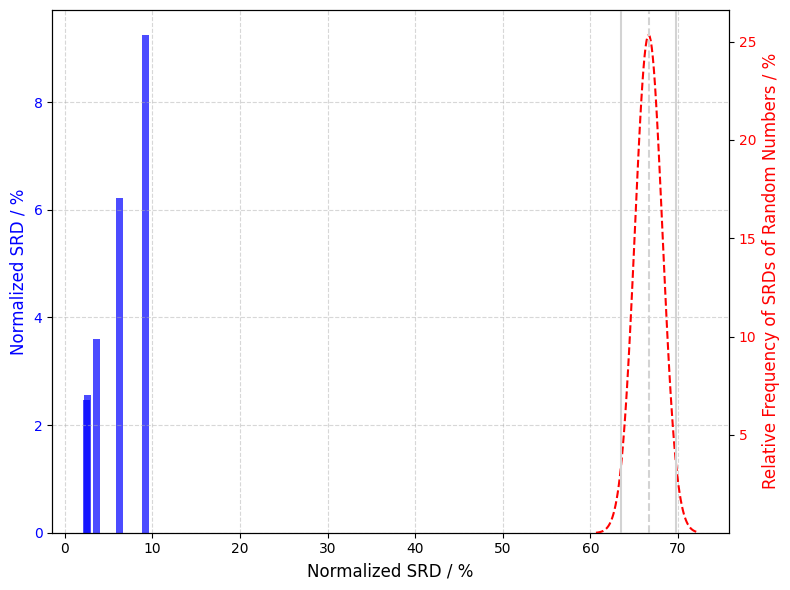

In [22]:
qsrr_srd_visualizer = SrdVisualizer(
    normalized_srds=normalized_srds,
    normalized_random_srds=normalized_random_srds
)
qsrr_srd_visualizer.visualize()

### SRD for iso2grad models

In [23]:
# Calculate SRD for iso2grad models
iso2grad_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, iso2grad_model in iso2grad_models.items():
    iso2grad_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = gradient time predictions
        inputs=iso2grad_model.results.gradient_retention_times.reshape(-1, 1),
        # Golden reference = exp gradient retention data
        golden_reference=iso2grad_data.gradient_retention_times.reshape(-1, 1)
    )

normalized_srds = np.hstack([iso2grad_srd.normalized_srds for iso2grad_srd in iso2grad_srds.values()])
normalized_random_srds = iso2grad_srds[RegressorType.PLS].normalized_random_srds  # Can take from any of the SRD objects as the numbers are random

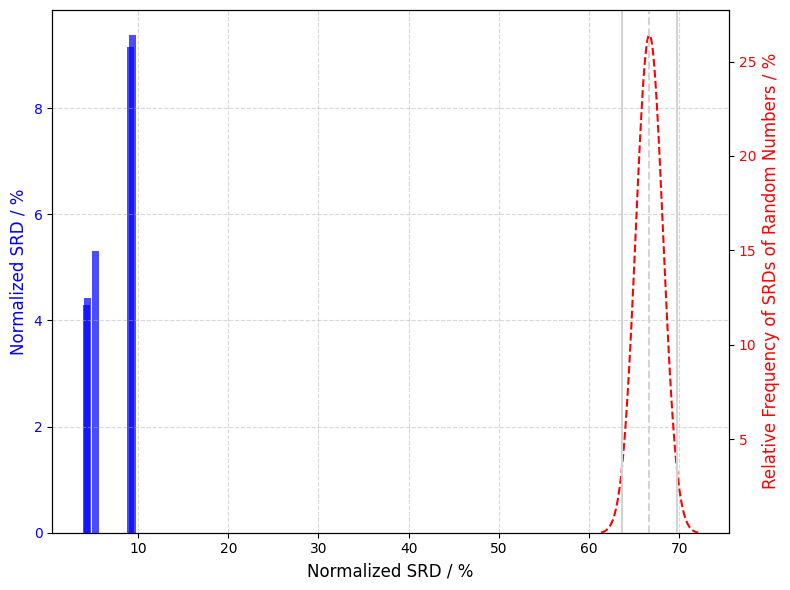

In [24]:
iso2grad_srd_visualizer = SrdVisualizer(
    normalized_srds=normalized_srds,
    normalized_random_srds=normalized_random_srds
)
iso2grad_srd_visualizer.visualize()

# Resampling with Replacement

In [32]:
# QSRR Models
bootstrapped_qsrr_models: Dict[RegressorType, List[QsrrModel]] = {}

if single_train_config.resampling_with_replacement_config is not None and single_train_config.resampling_with_replacement_config.use_resampling:

    for regressor_type, hyper_parameter_config in single_train_config.hyper_parameter_config.items():
        model_runner = QsrrResamplingWithReplacementModelRunner()
        bootstrapped_qsrr_models[regressor_type] = model_runner.run(
            regressor_type=regressor_type,
            config=single_train_config.resampling_with_replacement_config,
            hyper_parameter_config=hyper_parameter_config,
            train_test_config=single_train_config.train_test_split_config,
            qsrr_data=qsrr_data
        )

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    8.9s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    9.7s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:   10.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   10.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   10.7s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:   11.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   11.4s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:   11.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   12.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

In [33]:
bootstrapped_qsrr_models

{<RegressorType.PLS: 5>: [<qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x10e962fafd0>,
  ...],
 <RegressorType.xGB: 1>: [<qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x120c9bfa1c0>,
  ...],
 <RegressorType.GBR: 2>: [<qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x122595112b0>,
  ...],
 <RegressorType.RFR: 3>: [<qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x1246596cd00>,
  ...],
 <RegressorType.ADA: 4>: [<qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x12c4338ce50>,
  ...]}

In [34]:
def get_predictions(x, qsrr_model):
    return qsrr_model.model.predict(qsrr_model.scaler.transform(x))

In [35]:
pool = Parallel(n_jobs=12, verbose=10)

x = qsrr_data.x
y = qsrr_data.y

y_hats = {}

for regressor_type, qsrr_models_ in bootstrapped_qsrr_models.items():
    y_hats[regressor_type] = pool(delayed(get_predictions)(x, qsrr_model_) for qsrr_model_ in qsrr_models_)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    8.5s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    9.3s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    9.5s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    9.8s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   10.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:   10.7s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   11.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:   11.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   11.8s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

In [36]:
y_hats_arrs = {
    regressor_type:np.vstack(y_hats_) for regressor_type, y_hats_ in y_hats.items()
}

In [112]:
metrics = {}

In [113]:
metrics[RegressorType.PLS] = [get_metrics(qsrr_model_, RegressorType.PLS, idx) for idx, qsrr_model_ in enumerate(bootstrapped_qsrr_models[RegressorType.PLS])]

Processing PLS model 1
Processing PLS model 2
Processing PLS model 3
Processing PLS model 4
Processing PLS model 5
Processing PLS model 6
Processing PLS model 7
Processing PLS model 8
Processing PLS model 9
Processing PLS model 10
Processing PLS model 11
Processing PLS model 12
Processing PLS model 13
Processing PLS model 14
Processing PLS model 15
Processing PLS model 16
Processing PLS model 17
Processing PLS model 18
Processing PLS model 19
Processing PLS model 20
Processing PLS model 21
Processing PLS model 22
Processing PLS model 23
Processing PLS model 24
Processing PLS model 25
Processing PLS model 26
Processing PLS model 27
Processing PLS model 28
Processing PLS model 29
Processing PLS model 30
Processing PLS model 31
Processing PLS model 32
Processing PLS model 33
Processing PLS model 34
Processing PLS model 35
Processing PLS model 36
Processing PLS model 37
Processing PLS model 38
Processing PLS model 39
Processing PLS model 40
Processing PLS model 41
Processing PLS model 42
P

In [114]:
metrics[RegressorType.GBR] = [get_metrics(qsrr_model_, RegressorType.GBR, idx) for idx, qsrr_model_ in enumerate(bootstrapped_qsrr_models[RegressorType.GBR])]

Processing GBR model 1
Processing GBR model 2
Processing GBR model 3
Processing GBR model 4
Processing GBR model 5
Processing GBR model 6
Processing GBR model 7
Processing GBR model 8
Processing GBR model 9
Processing GBR model 10
Processing GBR model 11
Processing GBR model 12
Processing GBR model 13
Processing GBR model 14
Processing GBR model 15
Processing GBR model 16
Processing GBR model 17
Processing GBR model 18
Processing GBR model 19
Processing GBR model 20
Processing GBR model 21
Processing GBR model 22
Processing GBR model 23
Processing GBR model 24
Processing GBR model 25
Processing GBR model 26
Processing GBR model 27
Processing GBR model 28
Processing GBR model 29
Processing GBR model 30
Processing GBR model 31
Processing GBR model 32
Processing GBR model 33
Processing GBR model 34
Processing GBR model 35
Processing GBR model 36
Processing GBR model 37
Processing GBR model 38
Processing GBR model 39
Processing GBR model 40
Processing GBR model 41
Processing GBR model 42
P

In [115]:
metrics[RegressorType.xGB] = [get_metrics(qsrr_model_, RegressorType.xGB, idx) for idx, qsrr_model_ in enumerate(bootstrapped_qsrr_models[RegressorType.xGB])]

Processing xGB model 1
Processing xGB model 2
Processing xGB model 3
Processing xGB model 4
Processing xGB model 5
Processing xGB model 6
Processing xGB model 7
Processing xGB model 8
Processing xGB model 9
Processing xGB model 10
Processing xGB model 11
Processing xGB model 12
Processing xGB model 13
Processing xGB model 14
Processing xGB model 15
Processing xGB model 16
Processing xGB model 17
Processing xGB model 18
Processing xGB model 19
Processing xGB model 20
Processing xGB model 21
Processing xGB model 22
Processing xGB model 23
Processing xGB model 24
Processing xGB model 25
Processing xGB model 26
Processing xGB model 27
Processing xGB model 28
Processing xGB model 29
Processing xGB model 30
Processing xGB model 31
Processing xGB model 32
Processing xGB model 33
Processing xGB model 34
Processing xGB model 35
Processing xGB model 36
Processing xGB model 37
Processing xGB model 38
Processing xGB model 39
Processing xGB model 40
Processing xGB model 41
Processing xGB model 42
P

In [116]:
metrics[RegressorType.RFR] = [get_metrics(qsrr_model_, RegressorType.RFR, idx) for idx, qsrr_model_ in enumerate(bootstrapped_qsrr_models[RegressorType.RFR])]

Processing RFR model 1
Processing RFR model 2
Processing RFR model 3
Processing RFR model 4
Processing RFR model 5
Processing RFR model 6
Processing RFR model 7
Processing RFR model 8
Processing RFR model 9
Processing RFR model 10
Processing RFR model 11
Processing RFR model 12
Processing RFR model 13
Processing RFR model 14
Processing RFR model 15
Processing RFR model 16
Processing RFR model 17
Processing RFR model 18
Processing RFR model 19
Processing RFR model 20
Processing RFR model 21
Processing RFR model 22
Processing RFR model 23
Processing RFR model 24
Processing RFR model 25
Processing RFR model 26
Processing RFR model 27
Processing RFR model 28
Processing RFR model 29
Processing RFR model 30
Processing RFR model 31
Processing RFR model 32
Processing RFR model 33
Processing RFR model 34
Processing RFR model 35
Processing RFR model 36
Processing RFR model 37
Processing RFR model 38
Processing RFR model 39
Processing RFR model 40
Processing RFR model 41
Processing RFR model 42
P

In [117]:
metrics[RegressorType.ADA] = []

# Chunking to save memory

n_chunks = 10

for i in range(n_chunks):
    metrics[RegressorType.ADA].extend(
        [get_metrics(qsrr_model_, RegressorType.ADA, idx) for idx, qsrr_model_ in enumerate(bootstrapped_qsrr_models[RegressorType.ADA][i:1000+i])]
    )

Processing ADA model 1
Processing ADA model 2
Processing ADA model 3
Processing ADA model 4
Processing ADA model 5
Processing ADA model 6
Processing ADA model 7
Processing ADA model 8
Processing ADA model 9
Processing ADA model 10
Processing ADA model 11
Processing ADA model 12
Processing ADA model 13
Processing ADA model 14
Processing ADA model 15
Processing ADA model 16
Processing ADA model 17
Processing ADA model 18
Processing ADA model 19
Processing ADA model 20
Processing ADA model 21
Processing ADA model 22
Processing ADA model 23
Processing ADA model 24
Processing ADA model 25
Processing ADA model 26
Processing ADA model 27
Processing ADA model 28
Processing ADA model 29
Processing ADA model 30
Processing ADA model 31
Processing ADA model 32
Processing ADA model 33
Processing ADA model 34
Processing ADA model 35
Processing ADA model 36
Processing ADA model 37
Processing ADA model 38
Processing ADA model 39
Processing ADA model 40
Processing ADA model 41
Processing ADA model 42
P

In [119]:
assert len(metrics[RegressorType.ADA]) == 10000

In [120]:
for regressor_type in single_train_config.hyper_parameter_config:
    metrics[regressor_type] = {
        "rmse_train": np.vstack([metric["rmse_train"] for metric in metrics[regressor_type]]),
        "rmse_test": np.vstack([metric["rmse_test"] for metric in metrics[regressor_type]])
    }

In [37]:
# Indices of lower/upper CI
lower_idx = int(single_train_config.resampling_with_replacement_config.n_samples * 2.5 / 100)
upper_idx = single_train_config.resampling_with_replacement_config.n_samples - lower_idx

print(lower_idx)
print(upper_idx)

250
9750


In [38]:
y_hats_ = {}

for regressor_type, y_hat_arr in y_hats_arrs.items():
    y_hats_[regressor_type] = {}
    mean_ = np.mean(y_hat_arr.T, axis=1).reshape(-1, 1)
    lowers = []
    uppers = []
    for i in range(len(mean_)):
        y_i = sorted(y_hat_arr[:, i])
        mean_i = mean_[i]
        lowers.append(mean_i - y_i[lower_idx])
        uppers.append(y_i[upper_idx] - mean_i)
    y_hats_[regressor_type]["mean"] = mean_
    y_hats_[regressor_type]["lower"] = np.vstack(lowers).reshape(-1, 1)
    y_hats_[regressor_type]["upper"] = np.vstack(uppers).reshape(-1, 1)

In [121]:
def get_metric_ci(metrics, lidx, uidx):
    mean_ = np.mean(metrics)
    return {
        "mean": mean_,
        "lower": abs(mean_ - metrics[lidx]).item(),
        "upper": abs(metrics[uidx] - mean_).item()
    }
    

metrics_ = {}

for regressor_type, metrics_per_regressor in metrics.items():
    metrics_[regressor_type] = {
        "rmse_train": get_metric_ci(metrics=sorted(metrics_per_regressor["rmse_train"]), lidx=lower_idx, uidx=upper_idx),
        "rmse_test": get_metric_ci(metrics=sorted(metrics_per_regressor["rmse_test"]), lidx=lower_idx, uidx=upper_idx),
    }

In [122]:
metrics_

{<RegressorType.PLS: 5>: {'rmse_train': {'mean': 0.11650525920897065,
   'lower': 0.010880456875699898,
   'upper': 0.01095203265682429},
  'rmse_test': {'mean': 0.13253355017595342,
   'lower': 0.012148150946160563,
   'upper': 0.01712700789520938}},
 <RegressorType.GBR: 2>: {'rmse_train': {'mean': 0.006376144042281032,
   'lower': 0.0011893568364091823,
   'upper': 0.0013657020907954535},
  'rmse_test': {'mean': 0.04143704339920877,
   'lower': 0.009058863159050252,
   'upper': 0.012480372011838131}},
 <RegressorType.xGB: 1>: {'rmse_train': {'mean': 0.006736724276468129,
   'lower': 0.001241706315132065,
   'upper': 0.0014777455971966055},
  'rmse_test': {'mean': 0.04084997770432366,
   'lower': 0.009145099401818874,
   'upper': 0.012438779588624285}},
 <RegressorType.RFR: 3>: {'rmse_train': {'mean': 0.02329620081362495,
   'lower': 0.004627096626115514,
   'upper': 0.007251051893482366},
  'rmse_test': {'mean': 0.0610720020174062,
   'lower': 0.016408662955397127,
   'upper': 0.0363

In [123]:
from functools import reduce

dfs = []

for regressor_type, metrics__ in metrics_.items():
    df = pd.DataFrame.from_dict(metrics_[regressor_type], orient="index")
    df.columns = ["Mean RMSE", "Lower 95% C.I.", "Upper 95% C.I."]
    df.index = [f"{regressor_type.name} / training logk", f"{regressor_type.name} / testing logk"]
    dfs.append(df)

metrics_df = reduce(lambda left, right: pd.concat((left, right)), dfs)

In [125]:
print("Comparison of the performance characteristics of compared machine learning methods.")
display(metrics_df)

Comparison of the performance characteristics of compared machine learning methods.


,Mean RMSE,Lower 95% C.I.,Upper 95% C.I.
PLS / training logk,0.116505,0.010880,0.010952
PLS / testing logk,0.132534,0.012148,0.017127
GBR / training logk,0.006376,0.001189,0.001366
GBR / testing logk,0.041437,0.009059,0.012480
xGB / training logk,0.006737,0.001242,0.001478
xGB / testing logk,0.040850,0.009145,0.012439
RFR / training logk,0.023296,0.004627,0.007251
RFR / testing logk,0.061072,0.016409,0.036379
ADA / training logk,0.086382,0.007826,0.007974
ADA / testing logk,0.106336,0.014104,0.017877


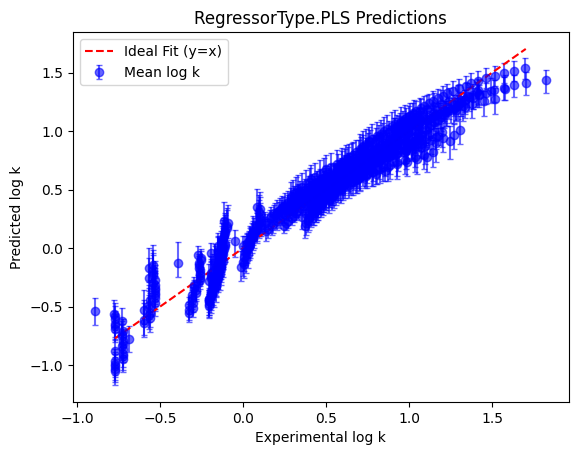

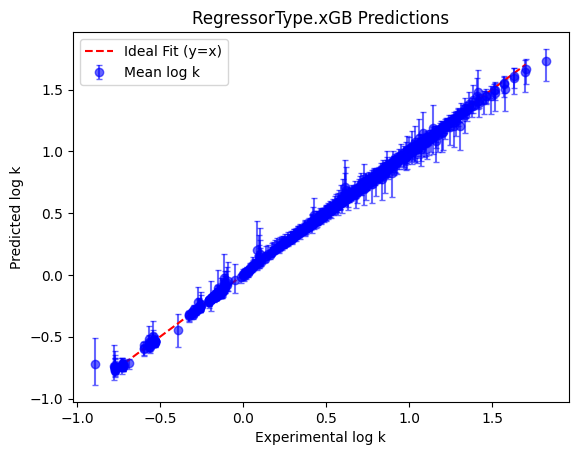

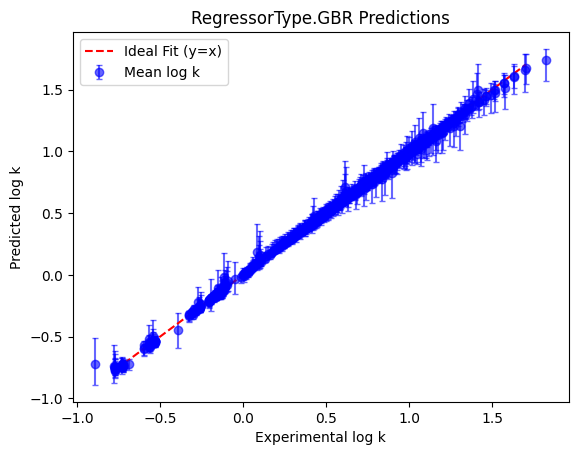

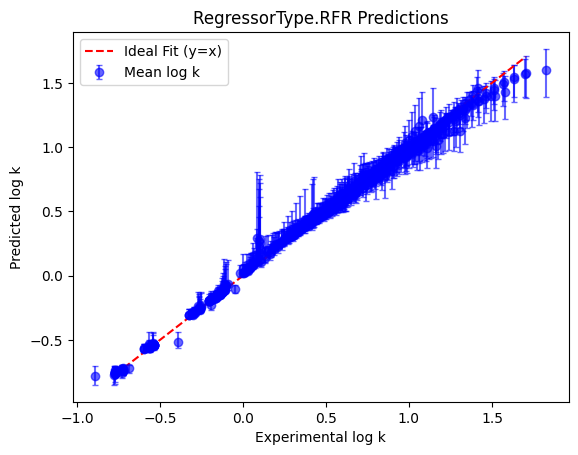

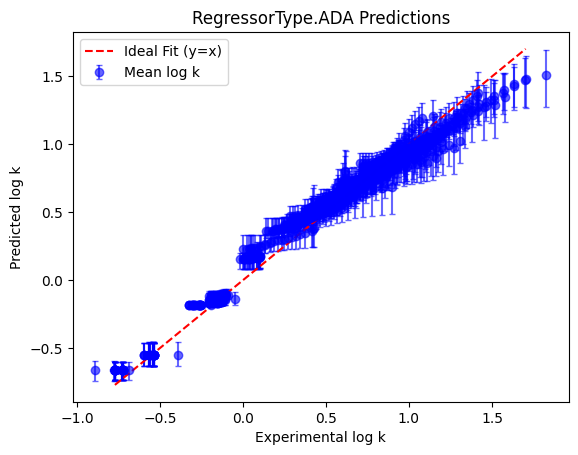

In [40]:
for regressor_type, y_hat in y_hats_.items():
    
    fig, ax = plt.subplots()

    ax.set_title(f"{regressor_type} Predictions")
    ax.set_xlabel("Experimental log k")
    ax.set_ylabel("Predicted log k")

    # Training data scatter plot
    ax.errorbar(
        x=y,
        y=y_hat["mean"].ravel(),
        yerr=np.hstack((y_hat["lower"], y_hat["upper"])).T,
        label="Mean log k",
        alpha=0.6,
        color="blue",
        fmt='o',
        capsize=2
    )
    
    # Diagonal reference line
    ax.plot(
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        color="red", linestyle="--", label="Ideal Fit (y=x)"
    )

    ax.legend()
    plt.show()

In [146]:
dfs = {}

for regressor_type in single_train_config.hyper_parameter_config:

    arr = np.vstack(
        [qsrr_data.y.ravel()] 
        + [y_hats_[regressor_type]["mean"].ravel(), y_hats_[regressor_type]["lower"].ravel(), y_hats_[regressor_type]["upper"].ravel()] 
        + y_hats[regressor_type]
    )

    df = pd.DataFrame(arr)
    df.index = ["experimental", "mean prediction", "lower 95% CI of prediction", "upper 95% CI of prediction"] + list(range(1, 10001))

    print(regressor_type)
    display(df)

    dfs[regressor_type] = df

RegressorType.PLS


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
experimental,0.729000,0.709000,0.672000,0.641000,0.613000,0.583000,0.567000,0.542000,0.506000,0.492000,...,0.591000,0.562000,0.550000,0.533000,0.515000,0.484000,0.470000,0.454000,0.439000,0.422000
mean prediction,0.705025,0.683646,0.662266,0.640886,0.619507,0.598127,0.576748,0.555368,0.533989,0.512609,...,0.501047,0.479667,0.458288,0.436908,0.415529,0.394149,0.372769,0.351390,0.330010,0.308631
lower 95% CI of prediction,0.065942,0.064170,0.062535,0.061255,0.059916,0.058960,0.057542,0.056350,0.055678,0.054956,...,0.113120,0.112391,0.111482,0.111366,0.110808,0.110808,0.109974,0.109737,0.109983,0.109824
upper 95% CI of prediction,0.060234,0.059367,0.058214,0.056907,0.056179,0.055447,0.054628,0.054219,0.053801,0.053977,...,0.089881,0.089996,0.089931,0.089814,0.089739,0.089733,0.090096,0.090757,0.091268,0.092448
1,0.662087,0.644328,0.626570,0.608811,0.591052,0.573293,0.555534,0.537775,0.520016,0.502258,...,0.542142,0.524383,0.506624,0.488865,0.471107,0.453348,0.435589,0.417830,0.400071,0.382312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.738639,0.717288,0.695936,0.674585,0.653234,0.631883,0.610532,0.589180,0.567829,0.546478,...,0.451608,0.430256,0.408905,0.387554,0.366203,0.344851,0.323500,0.302149,0.280798,0.259446
9997,0.598620,0.580470,0.562321,0.544171,0.526021,0.507872,0.489722,0.471572,0.453423,0.435273,...,0.562128,0.543979,0.525829,0.507679,0.489530,0.471380,0.453230,0.435081,0.416931,0.398781
9998,0.719568,0.697737,0.675907,0.654076,0.632246,0.610415,0.588585,0.566754,0.544924,0.523093,...,0.436512,0.414681,0.392851,0.371020,0.349190,0.327359,0.305529,0.283698,0.261868,0.240037
9999,0.692369,0.670023,0.647677,0.625331,0.602985,0.580639,0.558294,0.535948,0.513602,0.491256,...,0.526137,0.503791,0.481445,0.459099,0.436753,0.414407,0.392061,0.369715,0.347369,0.325023


RegressorType.xGB


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
experimental,0.729000,0.709000,0.672000,0.641000,0.613000,0.583000,0.567000,0.542000,0.506000,0.492000,...,0.591000,0.562000,0.550000,0.533000,0.515000,0.484000,0.470000,0.454000,0.439000,0.422000
mean prediction,0.763555,0.721988,0.682820,0.647614,0.616309,0.587479,0.561643,0.540249,0.515514,0.493759,...,0.586437,0.565905,0.544562,0.527492,0.509590,0.490884,0.473614,0.459808,0.442813,0.429404
lower 95% CI of prediction,0.090520,0.073988,0.064258,0.056645,0.054915,0.050909,0.051854,0.049962,0.045278,0.045579,...,0.030842,0.029957,0.029946,0.029420,0.028515,0.025694,0.025054,0.024768,0.024478,0.025013
upper 95% CI of prediction,0.130731,0.099592,0.078883,0.064953,0.057907,0.053872,0.048568,0.046849,0.049131,0.048694,...,0.029395,0.030023,0.028486,0.026623,0.026074,0.029641,0.031190,0.033023,0.035217,0.037371
1,0.775432,0.779797,0.683713,0.680273,0.666260,0.609374,0.579610,0.572999,0.487094,0.482492,...,0.594254,0.553437,0.530832,0.507130,0.500654,0.488492,0.478380,0.447424,0.435243,0.423744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.728417,0.696408,0.701318,0.655767,0.645864,0.593744,0.559700,0.533820,0.516538,0.504319,...,0.562826,0.557807,0.549748,0.530367,0.499595,0.488772,0.487100,0.470221,0.453709,0.439942
9997,0.779766,0.712337,0.703086,0.651453,0.601434,0.590797,0.531347,0.508791,0.488085,0.496878,...,0.601667,0.584004,0.552311,0.541734,0.504660,0.482290,0.480494,0.479203,0.433963,0.387735
9998,0.727875,0.712553,0.665933,0.644602,0.609302,0.590387,0.550483,0.530203,0.509521,0.483362,...,0.586210,0.585131,0.560955,0.557032,0.528506,0.514142,0.500127,0.455661,0.429175,0.425947
9999,0.730492,0.705413,0.662393,0.630110,0.614594,0.578256,0.558685,0.519582,0.539820,0.532062,...,0.592117,0.584917,0.558774,0.531026,0.519147,0.505808,0.482718,0.476326,0.453532,0.448122


RegressorType.GBR


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
experimental,0.729000,0.709000,0.672000,0.641000,0.613000,0.583000,0.567000,0.542000,0.506000,0.492000,...,0.591000,0.562000,0.550000,0.533000,0.515000,0.484000,0.470000,0.454000,0.439000,0.422000
mean prediction,0.758866,0.717674,0.679733,0.645572,0.615576,0.587559,0.561677,0.540691,0.516197,0.494109,...,0.586588,0.566192,0.544498,0.527505,0.509759,0.491290,0.473760,0.460032,0.443149,0.429770
lower 95% CI of prediction,0.100295,0.081612,0.070607,0.061791,0.056150,0.055466,0.055162,0.051752,0.047105,0.044569,...,0.031208,0.030357,0.030380,0.029914,0.028054,0.024767,0.025672,0.025732,0.026248,0.027223
upper 95% CI of prediction,0.131982,0.101961,0.078645,0.065674,0.058126,0.054224,0.049535,0.047937,0.050111,0.050619,...,0.031282,0.032131,0.028433,0.027926,0.026897,0.030066,0.033202,0.034731,0.037328,0.039160
1,0.711388,0.744756,0.689866,0.683587,0.638142,0.551489,0.527694,0.530242,0.488115,0.486298,...,0.584699,0.552542,0.533612,0.525283,0.505873,0.498820,0.497695,0.439226,0.430650,0.423892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.731099,0.728453,0.658270,0.619500,0.600091,0.574702,0.573902,0.540645,0.516897,0.500471,...,0.589108,0.587682,0.559465,0.532353,0.515696,0.487283,0.490121,0.480404,0.444408,0.437987
9997,0.847406,0.737893,0.707069,0.693117,0.660159,0.635456,0.608179,0.596089,0.547696,0.494076,...,0.594549,0.589708,0.546589,0.546619,0.511263,0.484845,0.476671,0.472038,0.460935,0.373324
9998,0.728141,0.713151,0.670844,0.666903,0.607519,0.590244,0.547445,0.528693,0.511195,0.490552,...,0.587129,0.572878,0.550931,0.550988,0.524972,0.490557,0.477332,0.453502,0.433394,0.424015
9999,0.728618,0.712173,0.682513,0.631893,0.619406,0.579108,0.537996,0.520111,0.553456,0.545963,...,0.590025,0.576532,0.552655,0.547743,0.515084,0.501764,0.495625,0.480283,0.455312,0.455312


RegressorType.RFR


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
experimental,0.729000,0.709000,0.672000,0.641000,0.613000,0.583000,0.567000,0.542000,0.506000,0.492000,...,0.591000,0.562000,0.550000,0.533000,0.515000,0.484000,0.470000,0.454000,0.439000,0.422000
mean prediction,0.790925,0.771622,0.737976,0.702073,0.666604,0.634672,0.606951,0.579698,0.550927,0.525023,...,0.580340,0.560199,0.541239,0.523477,0.505837,0.488701,0.474711,0.462654,0.452627,0.446163
lower 95% CI of prediction,0.091625,0.081188,0.071023,0.061407,0.055357,0.048592,0.043077,0.042044,0.041480,0.037703,...,0.041093,0.039879,0.038453,0.038184,0.037304,0.032441,0.030091,0.028441,0.028373,0.028696
upper 95% CI of prediction,0.161935,0.157392,0.142624,0.127947,0.110629,0.097908,0.087663,0.083809,0.080320,0.074230,...,0.031560,0.031015,0.029741,0.028770,0.030190,0.033832,0.037502,0.039226,0.041407,0.042964
1,0.682373,0.656647,0.644600,0.640567,0.638360,0.627853,0.609907,0.584973,0.541693,0.512313,...,0.568213,0.554120,0.526360,0.512253,0.496820,0.482013,0.464613,0.447280,0.442920,0.438607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.813113,0.810573,0.803660,0.736433,0.673593,0.616553,0.591007,0.580320,0.576860,0.544060,...,0.610167,0.593360,0.560567,0.537027,0.504787,0.494260,0.490860,0.482127,0.475880,0.469000
9997,0.749587,0.721193,0.706300,0.657013,0.642073,0.637087,0.597160,0.580567,0.574420,0.495060,...,0.591187,0.576533,0.557620,0.538447,0.496773,0.495293,0.483560,0.474020,0.453853,0.447827
9998,0.721987,0.707267,0.706720,0.666833,0.614927,0.590347,0.557807,0.536193,0.507173,0.490287,...,0.591407,0.574920,0.564173,0.547920,0.529220,0.471713,0.466980,0.454513,0.444680,0.444120
9999,0.747260,0.744733,0.730960,0.675440,0.645200,0.610320,0.576300,0.567627,0.552047,0.523107,...,0.589953,0.554740,0.538207,0.536260,0.518573,0.515647,0.504720,0.493753,0.485147,0.476900


RegressorType.ADA


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
experimental,0.729000,0.709000,0.672000,0.641000,0.613000,0.583000,0.567000,0.542000,0.506000,0.492000,...,0.591000,0.562000,0.550000,0.533000,0.515000,0.484000,0.470000,0.454000,0.439000,0.422000
mean prediction,0.767480,0.758190,0.740423,0.717619,0.692901,0.668297,0.644163,0.619110,0.592993,0.567532,...,0.606822,0.590512,0.576675,0.566050,0.558709,0.553765,0.550819,0.549240,0.548438,0.548171
lower 95% CI of prediction,0.113497,0.109190,0.099661,0.090264,0.083574,0.080395,0.084763,0.084381,0.085153,0.080490,...,0.076001,0.075744,0.075259,0.077250,0.078709,0.081865,0.083000,0.083812,0.084123,0.084388
upper 95% CI of prediction,0.099020,0.092995,0.089210,0.084335,0.078046,0.074297,0.073864,0.074490,0.073683,0.072117,...,0.068860,0.069714,0.070145,0.070091,0.069654,0.070569,0.070924,0.071660,0.071734,0.071896
1,0.655000,0.653338,0.652121,0.651811,0.640122,0.639471,0.606429,0.601167,0.563267,0.549000,...,0.558080,0.549676,0.536333,0.512282,0.512282,0.512282,0.512282,0.512282,0.512282,0.511000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.864630,0.864630,0.823161,0.773088,0.758917,0.717582,0.688605,0.678033,0.625879,0.578760,...,0.632400,0.620843,0.607698,0.594259,0.592590,0.591942,0.591231,0.591231,0.591231,0.591231
9997,0.734655,0.721444,0.721444,0.709533,0.709533,0.688556,0.651143,0.625744,0.575000,0.507894,...,0.635329,0.633976,0.608273,0.594687,0.583561,0.561632,0.561632,0.561632,0.561632,0.561632
9998,0.747792,0.745674,0.743042,0.734783,0.718698,0.708264,0.613250,0.546471,0.529788,0.483952,...,0.573815,0.565256,0.548889,0.546471,0.546471,0.546056,0.543857,0.543857,0.543857,0.543857
9999,0.769500,0.730768,0.729370,0.706395,0.678667,0.658955,0.621267,0.600377,0.541010,0.512043,...,0.626542,0.613083,0.601067,0.599947,0.597062,0.596783,0.591833,0.590783,0.590783,0.590783


# Save Results

In [127]:
# Define the prefix for saving
now = datetime.now()
date_string: str = f"{now.strftime('%y%m%d_%H%S-')}"

In [130]:
metrics_df.to_csv(
    os.path.join(
        RESULTS_PATH,
        f"{date_string}single_train-metrics.csv"
    )
)

In [147]:
for regressor_type, df in dfs.items():
    df.to_csv(
        os.path.join(
            RESULTS_PATH,
            f"{date_string}single_train-isocratic_qsrr_{regressor_type.name}_results.csv"
        )
    )